## Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import os 

Global seed set to 0


## Functions

In [2]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Set sampleID

In [3]:
sampleIDs = ['HCAHeartST11350375']
len(sampleIDs)

1

## Data, parameters

In [4]:
results_folder = '/nfs/team205/heart/cell2location'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures/'
run_name = f'{results_folder}/cell2location_map/'

In [5]:
visium_path='/nfs/team205/heart/mapped/spaceranger110/'

# celltype_key='cell_state'

regions = ['IVS_BASAL_LV/AX_latest','IVS_BASAL_LV/AX_withAVN-bundle']

## Loading visium data

In [6]:
# Read the data of the interested region into anndata objects
slides = []
for i in sampleIDs:
    slides.append(read_and_qc(i, path=visium_path))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sampleIDs,
    index_unique=None
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
# filter out low quality spots
sc.pp.filter_cells(adata_vis, min_counts = 500)
sc.pp.filter_cells(adata_vis, min_genes = 300)

# Spot number per slide
adata_vis.obs['sample'].value_counts()

HCAHeartST11350375    2843
Name: sample, dtype: int64

## Add annotation and remove 'none' and 'no_tissue' spots

In [8]:
path_to_annot='/nfs/team205/heart/visium_annotations/JC_annotations_csv'
category_name='annotation_JC'

In [9]:
# read in annotation csv file and concatenate
for i, ID in enumerate(sampleIDs):
    if f'{ID}_JC.csv' in os.listdir(path_to_annot):
    
        print(ID)
        annot_df = pd.read_csv(f'{path_to_annot}/{ID}_JC.csv')
        annot_df['spot_id']=ID+'_'+annot_df['Barcode']

        if i==0:
            annot_df_all=annot_df.copy()
        else:
            annot_df_all=pd.concat([annot_df_all,annot_df])
    else:
        print(f'{ID} is not annotated')

# add annotations to adata_vis
adata_vis.obs=pd.concat([adata_vis.obs,
                     annot_df_all.set_index('spot_id')[[category_name]].reindex(adata_vis.obs.index)],
                     axis=1)
# replace nan to 'none'
adata_vis.obs[category_name].fillna('none', inplace=True)

HCAHeartST11350375


In [10]:
pd.crosstab(adata_vis.obs['sample'],adata_vis.obs[category_name],)

annotation_JC,Endocardium,Fibrosis,LBB,Myocardium_ventricular,Purkinje cell,Vessel
sample,,,,,,
HCAHeartST11350375,18,191,245,2311,40,38


In [11]:
# filter out spots: remove 'none' and 'no_tissue'
adata_vis = adata_vis[adata_vis.obs[category_name].isin(['none','no_tissue'])==False]

# Spot number per slide
adata_vis.obs['sample'].value_counts()

HCAHeartST11350375    2843
Name: sample, dtype: int64

In [12]:
set(adata_vis.obs[category_name])

{'Endocardium',
 'Fibrosis',
 'LBB',
 'Myocardium_ventricular',
 'Purkinje cell',
 'Vessel'}

## Remove mitochondrial genes

In [13]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
print(sum(adata_vis.var['MT_gene']))
    
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
print(sum(adata_vis.var['MT_gene']))

Trying to set attribute `.var` of view, copying.


13
0


In [14]:
adata_vis.var.head()

,gene_ids,feature_types,genome,SYMBOL,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mt,MT_gene
ENSG00000243485,ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,0,0.000000,0.00000,100.000000,0.0,0.00000,False,False
ENSG00000237613,ENSG00000237613,Gene Expression,GRCh38,FAM138A,0,0.000000,0.00000,100.000000,0.0,0.00000,False,False
ENSG00000186092,ENSG00000186092,Gene Expression,GRCh38,OR4F5,0,0.000000,0.00000,100.000000,0.0,0.00000,False,False
ENSG00000238009,ENSG00000238009,Gene Expression,GRCh38,AL627309.1,6,0.002073,0.00207,99.792746,6.0,1.94591,False,False
ENSG00000239945,ENSG00000239945,Gene Expression,GRCh38,AL627309.3,0,0.000000,0.00000,100.000000,0.0,0.00000,False,False


## Run per region: cell2location mapping

####### IVS_BASAL_LV/AX_latest #######
HCAHeartST11350375    2843
Name: sample, dtype: int64
INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 2843 cells, 13177 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 2843  │
│             Vars             │ 13177 │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                         Batch Categories                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ HCAHeartST11350375 │          0          │
└─────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 45.07it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'annotation_JC' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'feature_types' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future 

####### IVS_BASAL_LV/AX_withAVN-bundle #######
HCAHeartST11350375    2843
Name: sample, dtype: int64
INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 2843 cells, 13286 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 2843  │
│             Vars             │ 13286 │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                         Batch Categories                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ HCAHeartST11350375 │          0          │
└─────────────────────┴────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:21<00:00, 45.90it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'annotation_JC' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'feature_types' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future 

CPU times: user 1h 21s, sys: 6min 14s, total: 1h 6min 35s
Wall time: 1h 6min 57s


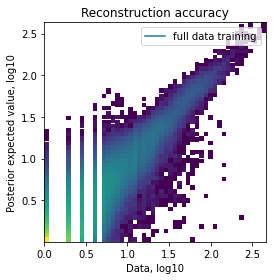

In [15]:
%%time

for reg in regions:
    print(f'####### {reg} #######')
    
    region_reference = reg.split('/')[1]

    adata_sub = adata_vis.copy()
    print(adata_sub.obs['sample'].value_counts())

    # read in reference signatures
    inf_aver = pd.read_csv(f"{ref_run_name}/{region_reference}/inf_aver.csv", index_col=0)

    # find shared genes and subset both anndata and reference signatures
    intersect = np.intersect1d(adata_sub.var_names, inf_aver.index)
    adata_sub = adata_sub[:, intersect].copy()
    inf_aver = inf_aver.loc[intersect, :].copy()

    # prepare anndata for cell2location model
    scvi.data.setup_anndata(adata=adata_sub, batch_key="sample")
    scvi.data.view_anndata_setup(adata_sub)

    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_sub, cell_state_df=inf_aver, 
        # the expected average cell abundance: tissue-dependent 
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=7,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection (using default here):
        detection_alpha=20
    ) 

    mod.train(max_epochs=20000, 
              # train using full data (batch_size=None)
              batch_size=None, 
              # use all data points in training because 
              # we need to estimate cell abundance at all locations
              train_size=1,
              use_gpu=True)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(1000)
    plt.legend(labels=['full data training']);

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_sub = mod.export_posterior(
        adata_sub, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{run_name}/{reg}", overwrite=True)

    # Save anndata object with results
    adata_sub.write(f"{run_name}/{reg}/sp.h5ad")

    # Examine reconstruction accuracy to assess if there are any issues with mapping
    # the plot should be roughly diagonal, strong deviations will signal problems
    mod.plot_QC()
    
    del mod, adata_sub, inf_aver, intersect, region_reference